In [3]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning);
warnings.filterwarnings("ignore", category=DeprecationWarning);
#Need to fix deprecation warning
warnings.filterwarnings("ignore");
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%config InlineBackend.figure_format = 'retina'


In [4]:
from hmmlearn.hmm import GaussianHMM
from hmm import GaussianFSHMM

## HMM and FSHMM testing

#### Generate synthetic data

We generate two features from an HMM following the parameters from the paper, and three features that are random noise. 

In [5]:
startprob = np.array([0.4, 0.6])

transmat = np.array([[0.75, 0.25],
                     [0.4, 0.6]])

means = np.array([[10.0,  20.0],
                  [30.0, 60.0]])

covars = 25.0 * np.tile(np.identity(2), (2, 1, 1))
model = GaussianHMM(n_components=2, covariance_type="diag")

model.startprob_ = startprob
model.transmat_ = transmat
model.means_ = means
model._covars_ = covars

In [6]:
X, Y = model.sample(500)

In [7]:
x1 = np.random.normal(0, 1, 500)
x2 = np.random.normal(0, 1, 500)
x3 = np.random.normal(0, 1, 500)

In [8]:
df = pd.DataFrame(X)
df['3'] = x1
df['4'] = x2
df['5'] = x3

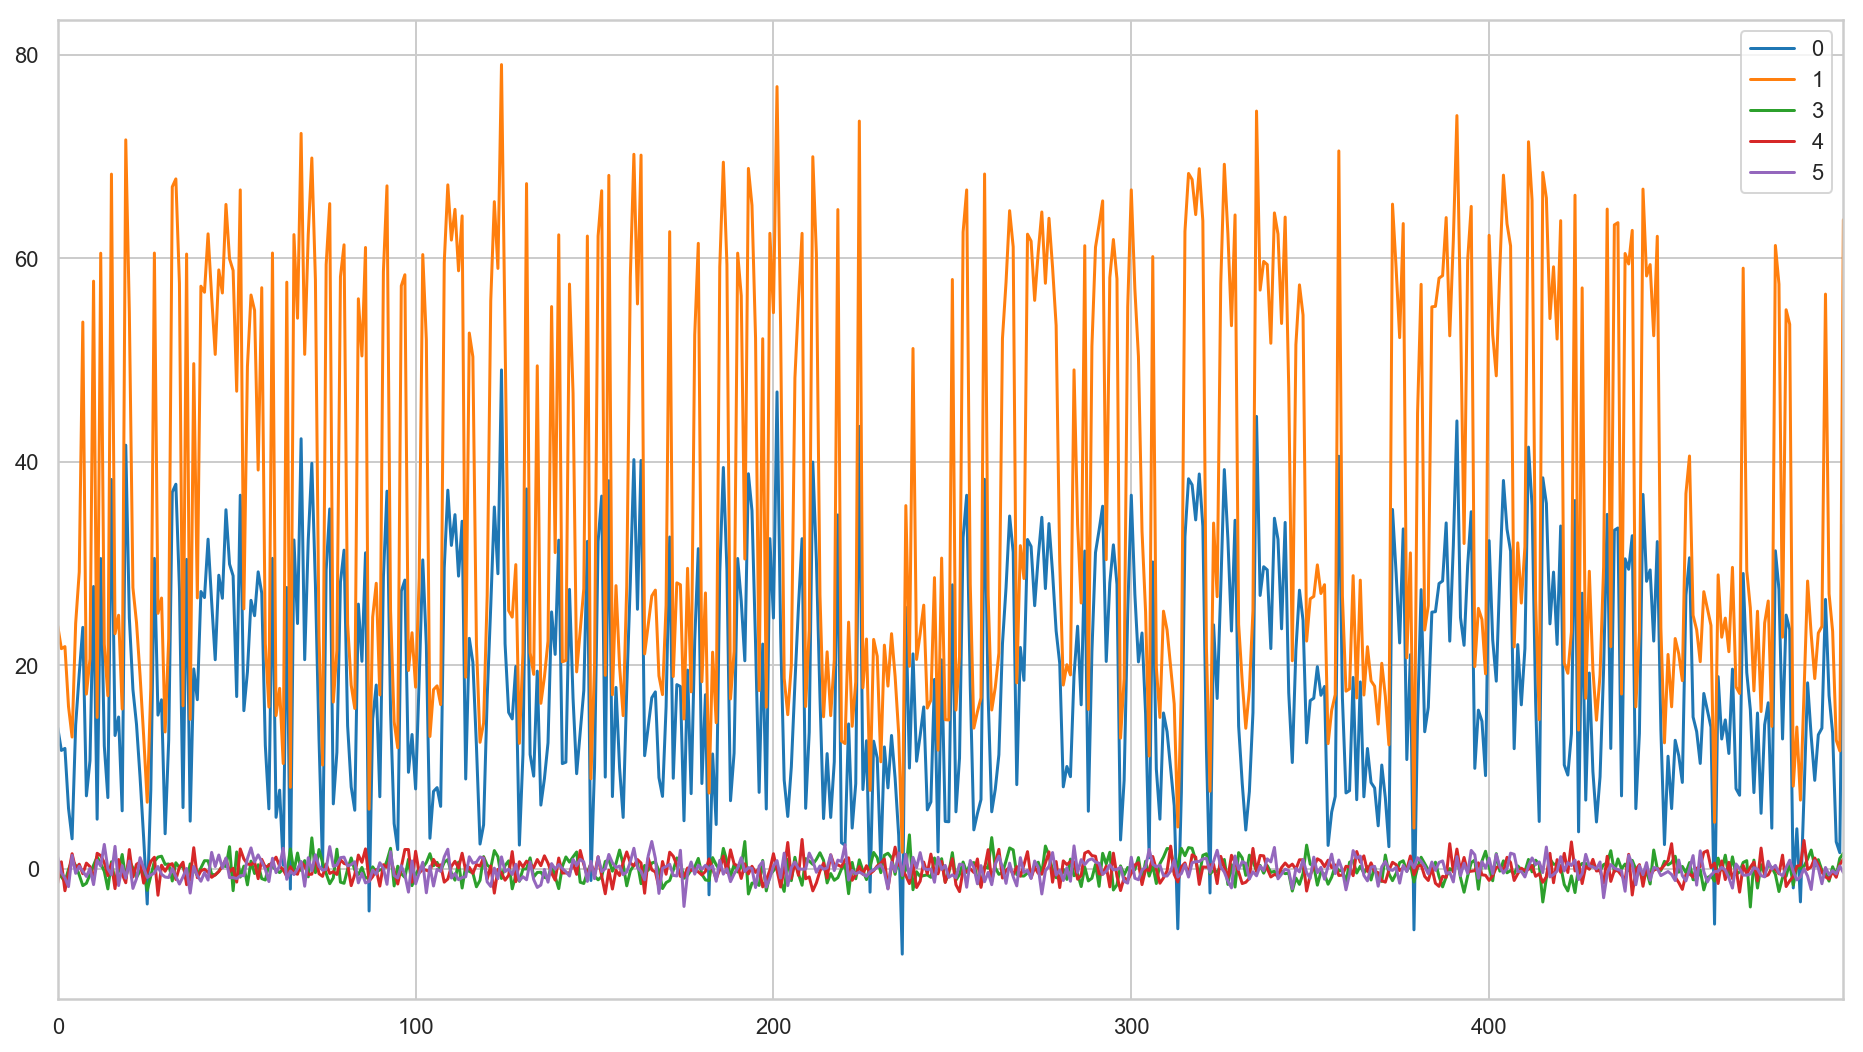

In [9]:
sns.set(style="whitegrid", palette="tab10")
df.plot(figsize=(16,9));

In [10]:
# To make the plot interactive using cufflinks uncomment the following
# import plotly
# import cufflinks as cf
# from plotly.offline import init_notebook_mode, plot, iplot
# import colorlover as cl

# plotly.offline.init_notebook_mode(connected=False)
# cf.set_config_file(offline=True, world_readable=False, theme='white')
# df.iplot()

### FSHMM

#### Test from paper

In [11]:
%reload_ext autoreload
%autoreload 2
from hmm import GaussianFSHMM

In [12]:
model_new_new = GaussianFSHMM(k=50, n_components=2, algorithm='viterbi', covariance_type="diag", init_params='m', n_iter=1000)

In [13]:
model_new_new.transmat_ = np.array([[0.5, 0.5], [0.5, 0.5]])
model_new_new.startprob_ = np.array([0.5, 0.5])
model_new_new._covars_ = 4.0 * np.tile(np.identity(5), (2, 1, 1))

In [14]:
df_norm = (df-df.mean())/df.std()
df_scaled = (df-df.min())/(df.max()-df.min())

In [15]:
# df_norm.iplot()
# df_scaled.iplot()

In [16]:
model_new_new.fit(df_norm)

GaussianFSHMM(k=None)

#### Feature saliencies of all features. First two saliencies are almost one and the last three features (added noise) are close to zero. 

In [17]:
rho_df = pd.DataFrame(model_new_new.rho_, index=['rho1', 'rho2', 'rho3', 'rho4', 'rho5'], columns=['Saliency']).T.round(3)
rho_df

,rho1,rho2,rho3,rho4,rho5
Saliency,0.982,0.957,0.0,0.0,0.035


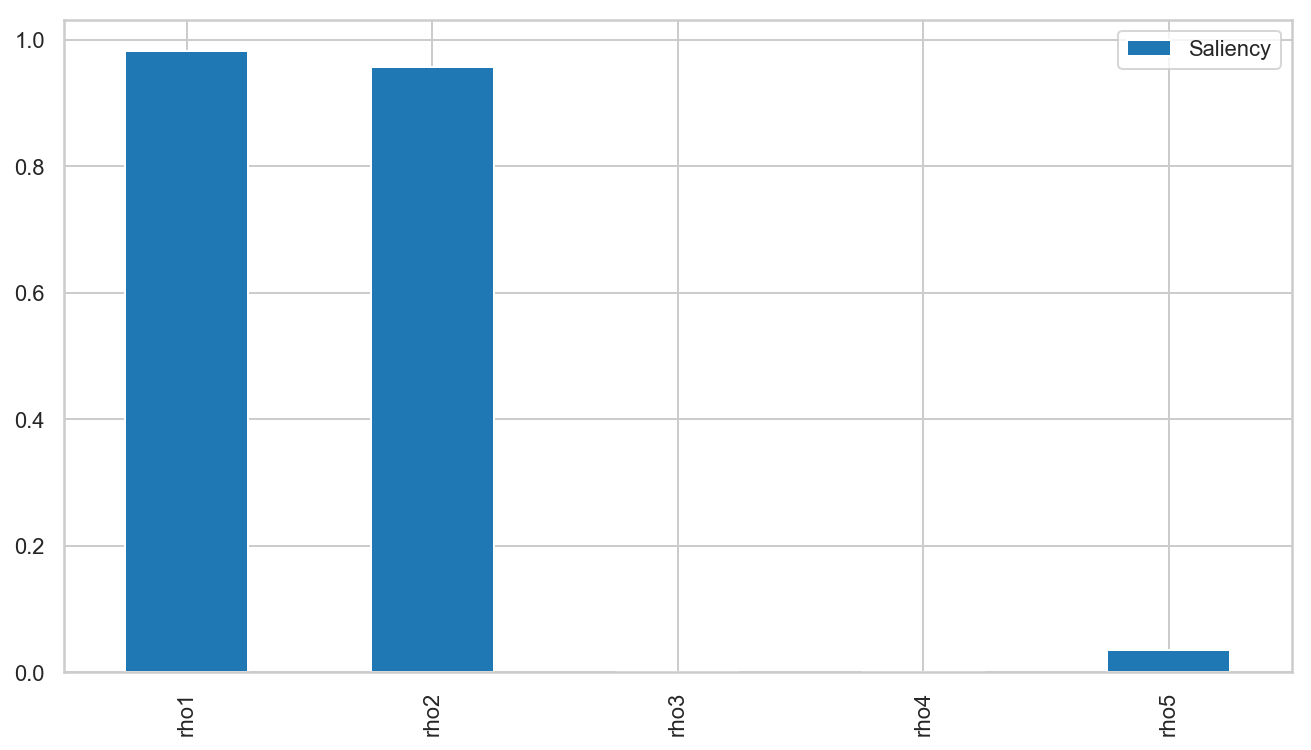

In [18]:
rho_df.T.plot.bar(figsize=(11,6));

In [19]:
model_new_new.monitor_.converged

True

In [20]:
model_new_new.monitor_

ConvergenceMonitor(history=[-5441.17401988895, -5441.1740198853095],
          iter=1000, n_iter=1000, tol=1e-09, verbose=False)

#### Transition matrix

The transition matrix from the original HMM was:
  
  
$$\begin{pmatrix}
           0.75 & 0.25\\
           0.4, & 0.6
    \end{pmatrix}$$


In [21]:
pd.DataFrame(model_new_new.transmat_).round(3)

,0,1
0,0.73,0.27
1,0.37,0.63


#### Parameter estimates for $\mu$
The means for the two-state HMM were:  
  
  
$$\begin{align}
    S0_{\mu} = 
        \begin{pmatrix}
            10\\
           20
    \end{pmatrix}
    \qquad
    S1_{\mu} = 
        \begin{pmatrix}
            30\\
           60
    \end{pmatrix}
    \nonumber
  \end{align}$$
    
and the other three time series had a mean of 0.



In [22]:
pd.DataFrame((model_new_new.means_)*np.array(df.std())+np.array(df.mean()), columns=['mu1', 'mu2', 'mu3', 'mu4', 'mu5'], index=['S0', 'S1']).round(3)

,mu1,mu2,mu3,mu4,mu5
S0,10.347,20.180,-1.094,-1.006,-1.293
S1,30.139,60.239,0.999,0.980,1.017


#### Parameter estimates for $\sigma$

The variances for the two-state HMM were:  
  
  
$$\begin{align}
    S0_{\sigma^2} = 
        \begin{pmatrix}
            25\\
           25
    \end{pmatrix}
    \qquad
    S1_{\sigma^2} = 
        \begin{pmatrix}
            25\\
           25
    \end{pmatrix}
    \nonumber
  \end{align}$$
    
therefore the std for each component and each state was 5, and the other three time series had a std of 1.



In [23]:
pd.DataFrame(np.sqrt((model_new_new._covars_)*np.array(df.std())+np.array(df.mean())), columns=['sigma1', 'sigma2', 'sigma3', 'sigma4', 'sigma5'], index=['S0', 'S1']).round(3)

,sigma1,sigma2,sigma3,sigma4,sigma5
S0,4.694,6.235,0.549,0.564,0.974
S1,4.690,6.241,0.549,0.564,0.492


#### Parameter estimates for $\epsilon$, the last three values (the irrelevant features) are close to zero, which is the true value.

In [24]:
pd.DataFrame(model_new_new.epsilon_, index=['eps1', 'eps2', 'eps3', 'eps4', 'eps5'], columns=['MAP']).T.round(3)

,eps1,eps2,eps3,eps4,eps5
MAP,-0.012,0.097,-0.0,0.0,0.014


#### Parameter estimates for $\tau$, the last three features are close to one, which is the true value.

In [25]:
pd.DataFrame(model_new_new.tau_, index=['tau1', 'tau2', 'tau3', 'tau4', 'tau5'], columns=['MAP']).T.round(3)

,tau1,tau2,tau3,tau4,tau5
MAP,0.653,0.703,0.997,0.997,0.966


In [26]:
# HTML('''<script>
# MathJax.Hub.Queue(["Typeset",MathJax.Hub,""]);
# </script>''')